In [1]:
import pipeline
import pandas as pd

In [2]:
df = pipeline.read_load('/Users/erhla/Downloads/projects_2012_2013.csv')
#convert columns to datetime and add outcome column
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])
df['days_to_fund'] = df['datefullyfunded'] - df['date_posted']
df['funded_within_60_days'] = pd.get_dummies(df['days_to_fund'] <= pd.Timedelta('60 days'), drop_first=True)

cols_to_fill = ['students_reached']
cols_to_drop_nas = ['primary_focus_area', 'resource_type', 'grade_level']
y_col = 'funded_within_60_days'

In [3]:
feature_dict = {'students_reached': 'discretized',
                'total_price_including_optional_support': 'discretized',
                'school_charter': 'dummy',
                'school_magnet': 'dummy',
                'eligible_double_your_impact_match': 'dummy',
                'teacher_prefix': 'dummy',
                'poverty_level': 'dummy',
                'grade_level': 'dummy',
                'primary_focus_area': 'dummy',
                'resource_type': 'dummy'
               }


In [4]:
df = pipeline.preprocess(df, cols_to_fill, cols_to_drop_nas)

53 nas filled for students_reached


In [5]:
df, feature_ls = pipeline.generate_features(df, feature_dict, 10)

students_reached discretized
total_price_including_optional_support discretized
school_charter has values:  ['f' 't']
dummy created for school_charter
school_magnet has values:  ['f' 't']
dummy created for school_magnet
eligible_double_your_impact_match has values:  ['f' 't']
dummy created for eligible_double_your_impact_match
teacher_prefix has values:  ['Mrs.' 'Ms.' 'Mr.' 'Dr.']
target variable has more than two values, multiple dummies created
poverty_level has values:  ['highest poverty' 'high poverty' 'low poverty' 'moderate poverty']
target variable has more than two values, multiple dummies created
grade_level has values:  ['Grades PreK-2' 'Grades 3-5' 'Grades 9-12' 'Grades 6-8']
target variable has more than two values, multiple dummies created
primary_focus_area has values:  ['Math & Science' 'History & Civics' 'Literacy & Language'
 'Applied Learning' 'Music & The Arts' 'Health & Sports' 'Special Needs']
target variable has more than two values, multiple dummies created
resou

In [6]:
df = pipeline.create_clusters(df, feature_ls, 5)

VARIABLE: students_reached 
 count     24864
unique        5
top           8
freq       6302
Name: students_reached, dtype: int64 

VARIABLE: total_price_including_optional_support 
 count     24864
unique        5
top           3
freq       5764
Name: total_price_including_optional_support, dtype: int64 

VARIABLE: school_charter 
 count     24864
unique        2
top          -1
freq      22079
Name: school_charter, dtype: int64 

VARIABLE: school_magnet 
 count     24864
unique        2
top          -1
freq      22361
Name: school_magnet, dtype: int64 

VARIABLE: eligible_double_your_impact_match 
 count     24864
unique        2
top          -1
freq      16500
Name: eligible_double_your_impact_match, dtype: int64 

VARIABLE: teacher_prefix_Dr. 
 count    24864.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: teacher_prefix_Dr., dtype: float64 

VARIABLE: teacher_prefix_Mr. 
 count    24864.000000
mean     

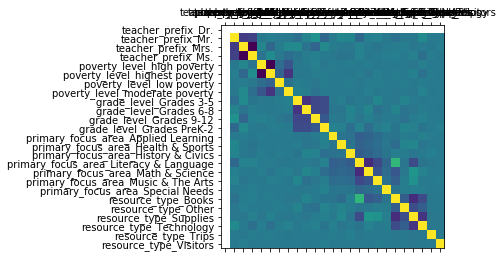

C:\Users\erhla\Anaconda3\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\erhla\Documents\GitHub\machine-learning\hw4\pipeline.py:56: RuntimeWarning: invalid value encountered in greater
  outliers = current[(np.abs(stats.zscore(current)) > 5)] #find values 5+ sds


poverty_level_low poverty has possible outliers 556 

primary_focus_area_Special Needs has possible outliers 678 

resource_type_Trips has possible outliers 32 

resource_type_Visitors has possible outliers 15 

VARIABLE: students_reached 
 count     20148
unique        5
top           6
freq       7798
Name: students_reached, dtype: int64 

VARIABLE: total_price_including_optional_support 
 count     20148
unique        5
top           6
freq       6176
Name: total_price_including_optional_support, dtype: int64 

VARIABLE: school_charter 
 count     20148
unique        2
top          -1
freq      18196
Name: school_charter, dtype: int64 

VARIABLE: school_magnet 
 count     20148
unique        2
top          -1
freq      18520
Name: school_magnet, dtype: int64 

VARIABLE: eligible_double_your_impact_match 
 count     20148
unique        2
top          -1
freq      13570
Name: eligible_double_your_impact_match, dtype: int64 

VARIABLE: teacher_prefix_Dr. 
 count    20148.000000
mean   

correlation with: resource_type_Technology 

 resource_type_Books      -0.400799
resource_type_Other      -0.253184
resource_type_Supplies   -0.499088
Name: resource_type_Technology, dtype: float64 




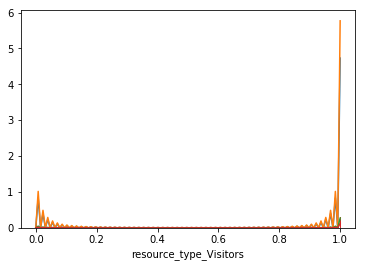

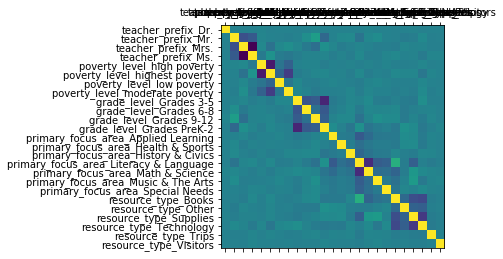

teacher_prefix_Dr. has possible outliers 1 

poverty_level_low poverty has possible outliers 640 

primary_focus_area_Health & Sports has possible outliers 379 

primary_focus_area_History & Civics has possible outliers 764 

resource_type_Trips has possible outliers 85 

resource_type_Visitors has possible outliers 14 

VARIABLE: students_reached 
 count     30079
unique        5
top           1
freq       7683
Name: students_reached, dtype: int64 

VARIABLE: total_price_including_optional_support 
 count     30079
unique        5
top           1
freq       7194
Name: total_price_including_optional_support, dtype: int64 

VARIABLE: school_charter 
 count     30079
unique        2
top          -1
freq      27714
Name: school_charter, dtype: int64 

VARIABLE: school_magnet 
 count     30079
unique        2
top          -1
freq      27846
Name: school_magnet, dtype: int64 

VARIABLE: eligible_double_your_impact_match 
 count     30079
unique        2
top          -1
freq      20306
Name:

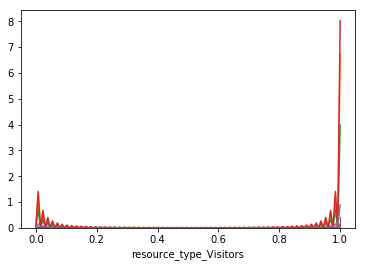

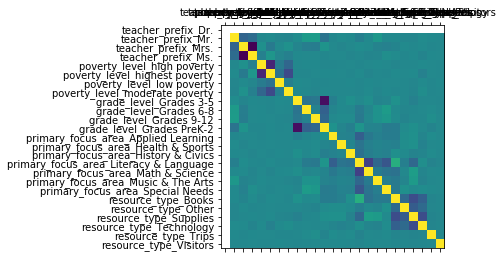

C:\Users\erhla\Anaconda3\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\erhla\Documents\GitHub\machine-learning\hw4\pipeline.py:56: RuntimeWarning: invalid value encountered in greater
  outliers = current[(np.abs(stats.zscore(current)) > 5)] #find values 5+ sds


poverty_level_low poverty has possible outliers 719 

primary_focus_area_Health & Sports has possible outliers 561 

primary_focus_area_History & Civics has possible outliers 746 

resource_type_Trips has possible outliers 53 

resource_type_Visitors has possible outliers 10 

VARIABLE: students_reached 
 count     25558
unique        5
top          10
freq       7009
Name: students_reached, dtype: int64 

VARIABLE: total_price_including_optional_support 
 count     25558
unique        5
top          10
freq       7694
Name: total_price_including_optional_support, dtype: int64 

VARIABLE: school_charter 
 count     25558
unique        2
top          -1
freq      22776
Name: school_charter, dtype: int64 

VARIABLE: school_magnet 
 count     25558
unique        2
top          -1
freq      22955
Name: school_magnet, dtype: int64 

VARIABLE: eligible_double_your_impact_match 
 count     25558
unique        2
top          -1
freq      19327
Name: eligible_double_your_impact_match, dtype: in

correlation with: grade_level_Grades 9-12 

 grade_level_Grades 3-5   -0.378721
grade_level_Grades 6-8   -0.409573
Name: grade_level_Grades 9-12, dtype: float64 


correlation with: grade_level_Grades PreK-2 

 grade_level_Grades 6-8   -0.269447
Name: grade_level_Grades PreK-2, dtype: float64 


correlation with: primary_focus_area_Literacy & Language 

 primary_focus_area_Math & Science     -0.473020
primary_focus_area_Music & The Arts   -0.270382
resource_type_Books                    0.393955
Name: primary_focus_area_Literacy & Language, dtype: float64 


correlation with: primary_focus_area_Math & Science 

 primary_focus_area_Literacy & Language   -0.473020
primary_focus_area_Music & The Arts      -0.310747
Name: primary_focus_area_Math & Science, dtype: float64 


correlation with: primary_focus_area_Music & The Arts 

 primary_focus_area_Literacy & Language   -0.270382
primary_focus_area_Math & Science        -0.310747
Name: primary_focus_area_Music & The Arts, dtype: float64 



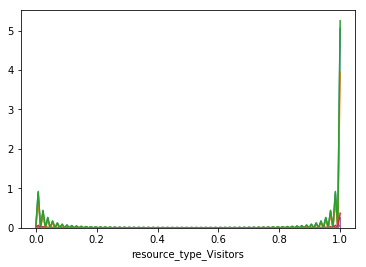

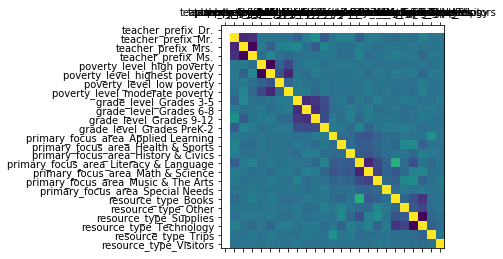

C:\Users\erhla\Anaconda3\lib\site-packages\scipy\stats\stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\erhla\Documents\GitHub\machine-learning\hw4\pipeline.py:56: RuntimeWarning: invalid value encountered in greater
  outliers = current[(np.abs(stats.zscore(current)) > 5)] #find values 5+ sds


primary_focus_area_Special Needs has possible outliers 649 

resource_type_Trips has possible outliers 389 

resource_type_Visitors has possible outliers 81 

VARIABLE: students_reached 
 count     24307
unique        5
top           3
freq       6477
Name: students_reached, dtype: int64 

VARIABLE: total_price_including_optional_support 
 count     24307
unique        5
top           9
freq       5499
Name: total_price_including_optional_support, dtype: int64 

VARIABLE: school_charter 
 count     24307
unique        2
top          -1
freq      22556
Name: school_charter, dtype: int64 

VARIABLE: school_magnet 
 count     24307
unique        2
top          -1
freq      22573
Name: school_magnet, dtype: int64 

VARIABLE: eligible_double_your_impact_match 
 count     24307
unique        2
top          -1
freq      18170
Name: eligible_double_your_impact_match, dtype: int64 

VARIABLE: teacher_prefix_Dr. 
 count    24307.000000
mean         0.000041
std          0.006414
min          0.0

correlation with: grade_level_Grades 9-12 

 grade_level_Grades PreK-2   -0.284573
Name: grade_level_Grades 9-12, dtype: float64 


correlation with: grade_level_Grades PreK-2 

 grade_level_Grades 3-5    -0.789276
grade_level_Grades 6-8    -0.298410
grade_level_Grades 9-12   -0.284573
Name: grade_level_Grades PreK-2, dtype: float64 


correlation with: primary_focus_area_Applied Learning 

 primary_focus_area_Literacy & Language   -0.286717
Name: primary_focus_area_Applied Learning, dtype: float64 


correlation with: primary_focus_area_Literacy & Language 

 primary_focus_area_Applied Learning   -0.286717
primary_focus_area_Math & Science     -0.534009
primary_focus_area_Special Needs      -0.369625
resource_type_Books                    0.264692
Name: primary_focus_area_Literacy & Language, dtype: float64 


correlation with: primary_focus_area_Math & Science 

 primary_focus_area_Literacy & Language   -0.534009
Name: primary_focus_area_Math & Science, dtype: float64 


correlation 

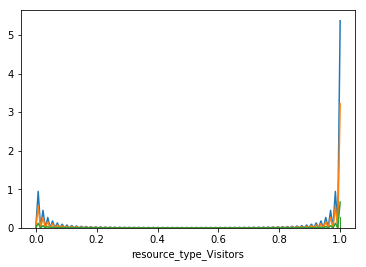

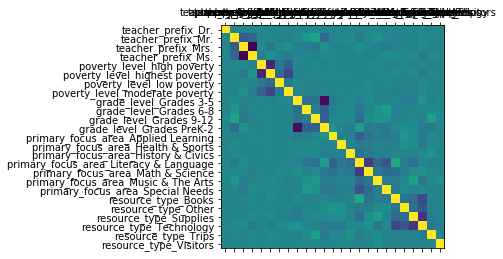

teacher_prefix_Dr. has possible outliers 1 

poverty_level_low poverty has possible outliers 821 

primary_focus_area_Health & Sports has possible outliers 333 

primary_focus_area_History & Civics has possible outliers 640 

resource_type_Trips has possible outliers 143 

resource_type_Visitors has possible outliers 23 



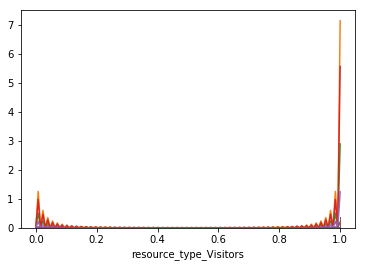

In [7]:
pipeline.explore_clusters(df, feature_ls, y_col)

In [8]:
pipeline.explore_clusters_2(df, feature_ls, y_col, 0.2)



 0 


total_price_including_optional_support has feature importance:  0.6288953908254794


 1 


eligible_double_your_impact_match has feature importance:  0.22875519280131454


 2 


total_price_including_optional_support has feature importance:  0.6989747039199008
eligible_double_your_impact_match has feature importance:  0.2135372379859101


 3 


eligible_double_your_impact_match has feature importance:  0.32748703849014554


 4 


total_price_including_optional_support has feature importance:  0.2824596453331105
eligible_double_your_impact_match has feature importance:  0.3427306437639621


In [9]:
df = pipeline.merge_cluster(df, [2, 3])

In [10]:
df = pipeline.split_cluster(df, feature_ls, 4, 3)